<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/sfm_to_intrinsic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/tancredeguillou/StructureFromMotion.git

Cloning into 'StructureFromMotion'...
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (156/156), 61.20 MiB | 44.60 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [2]:
%cd StructureFromMotion

/content/StructureFromMotion


In [4]:
%cd code

/content/StructureFromMotion/code


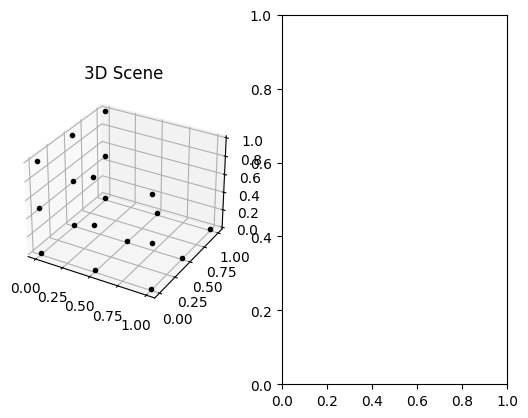

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0006253538899291128
            Iterations: 15
            Function evaluations: 209
            Gradient evaluations: 15
Reprojection error after optimization: 0.0006253538899291128
K=
[[2.713e+03 3.313e+00 1.481e+03]
 [0.000e+00 2.710e+03 9.654e+02]
 [0.000e+00 0.000e+00 1.000e+00]]
R =
[[-0.774  0.633 -0.007]
 [ 0.309  0.369 -0.877]
 [-0.552 -0.681 -0.481]]
t = [[0.047 0.054 3.441]]


In [6]:
import matplotlib.pyplot as plt
import numpy as np

from impl.vis import Plot2DPoints, PlotProjectedPoints, Plot3DPoints, PlotCamera
from impl.calib.geometry import NormalizePoints2D, NormalizePoints3D, EstimateProjectionMatrix, DecomposeP
from impl.calib.io import ReadPoints2D, ReadPoints3D, ReadImageSize
from impl.calib.opt import ImageResiduals, OptimizeProjectionMatrix


def main():

  np.set_printoptions(precision=3)

  # Load the point correspondences
  # Each row is a point. Corresponding points are in the same rows in `points2D` and `points3D`, respectively.
  # 2D points as Nx2 array with [x, y] coordinates
  points2D = ReadPoints2D('../data')
  # 3D points as Nx3 array with [X, Y, Z] coordinates
  points3D = ReadPoints3D('../data')
  # Image size as [width, height]
  image_size = ReadImageSize('../data')

  # Visualize
  fig = plt.figure()
  ax3d = fig.add_subplot(121, projection='3d')
  ax2d = fig.add_subplot(122)
  Plot3DPoints(points3D, ax3d)
  Plot2DPoints(points2D, image_size, ax2d)
  plt.show(block=False)

  # Normalize 2D and 3D points
  normalized_points2D, T2D = NormalizePoints2D(points2D, image_size)
  normalized_points3D, T3D = NormalizePoints3D(points3D)

  # Estimate the projection matrix from normalized correspondences
  P_hat = EstimateProjectionMatrix(normalized_points2D, normalized_points3D)

  # Optimize based on reprojection error
  P_hat_opt = OptimizeProjectionMatrix(P_hat, normalized_points2D, normalized_points3D)

  print(f'Reprojection error after optimization: {np.linalg.norm(ImageResiduals(P_hat_opt, normalized_points2D, normalized_points3D))**2}')

  # Denormalize P
  P = (np.linalg.inv(T2D) @ P_hat_opt) @ T3D

  # Decompose P
  K, R, t = DecomposeP(P)

  # Print the estimated values
  print(f'K=\n{K/K[2,2]}')
  print(f'R =\n{R}')
  print(f't = {t.transpose()}')

  # Visualize
  PlotCamera(R, t, ax3d, 0.5)
  PlotProjectedPoints(points3D, points2D, K, R, t, image_size, ax2d)

  # Make sure the plots are shown before the program terminates
  plt.show()

if __name__ == "__main__":
  main()